<a href="https://colab.research.google.com/github/gordhansingh88/Melanoma-Skin-Cancer-Detection/blob/main/Gordhan_Singh_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem statement:
Develop a Convolutional Neural Network (CNN) model capable of precisely identifying melanoma, a potentially fatal form of cancer that accounts for 70-80% of skin cancer fatalities. This model can aid in reducing the amount of manual work required in the diagnosis process by assessing images and notifying dermatologists of the presence of melanoma, potentially saving lives by detecting the disease early.

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#unzip the dataset
#!unzip "/content/gdrive/MyDrive/SkinCancerDataset.zip" > /dev/null/

In [5]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img

In [6]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin_cancer/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin_cancer/Test")

In [7]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization**

Found 2239 files belonging to 9 classes.


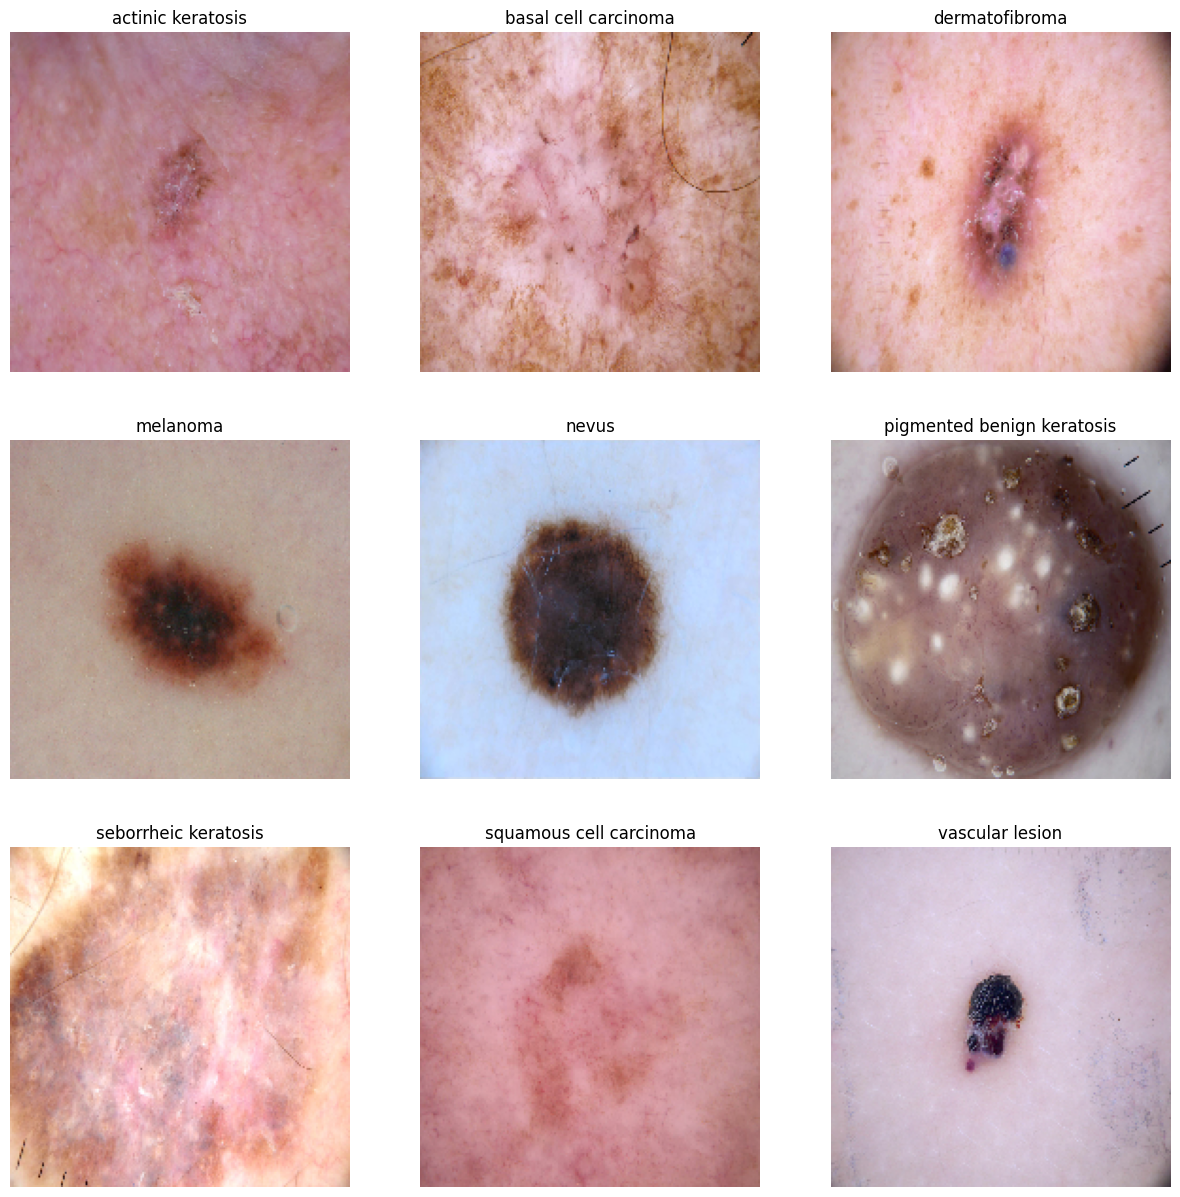

In [8]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                    batch_size=32,
                                                                    image_size=(180,180),
                                                                    label_mode='categorical',
                                                                    seed=123)
#all the classes of Skin Cancer

class_names = image_dataset.class_names


#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3, index)
    plt.imshow(load_img(path_list[0],target_size=(180, 180)))
    plt.title(c)
    plt.axis('off')

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Visualize distribution of classes in the training dataset.**

In [9]:
def class_distribution_count(directory):

    #count number of images in each classes
    count=[]
    for path in pathlib.Path(directory).iterdir():
      if path.is_dir():
        count.append(len([name for name in os.listdir(path)
                            if os.path.isfile(os.path.join(path, name))]))
      
    # name of the classes
    sub_directory = [name for name in os.listdir(directory)
                     if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)), columns=['Class', 'Image_count'])

  
df = class_distribution_count(data_dir_train)
df

,Class,Image_count
0,squamous cell carcinoma,181
1,melanoma,438
2,basal cell carcinoma,376
3,actinic keratosis,114
4,pigmented benign keratosis,462
5,dermatofibroma,95
6,nevus,357
7,vascular lesion,139
8,seborrheic keratosis,77


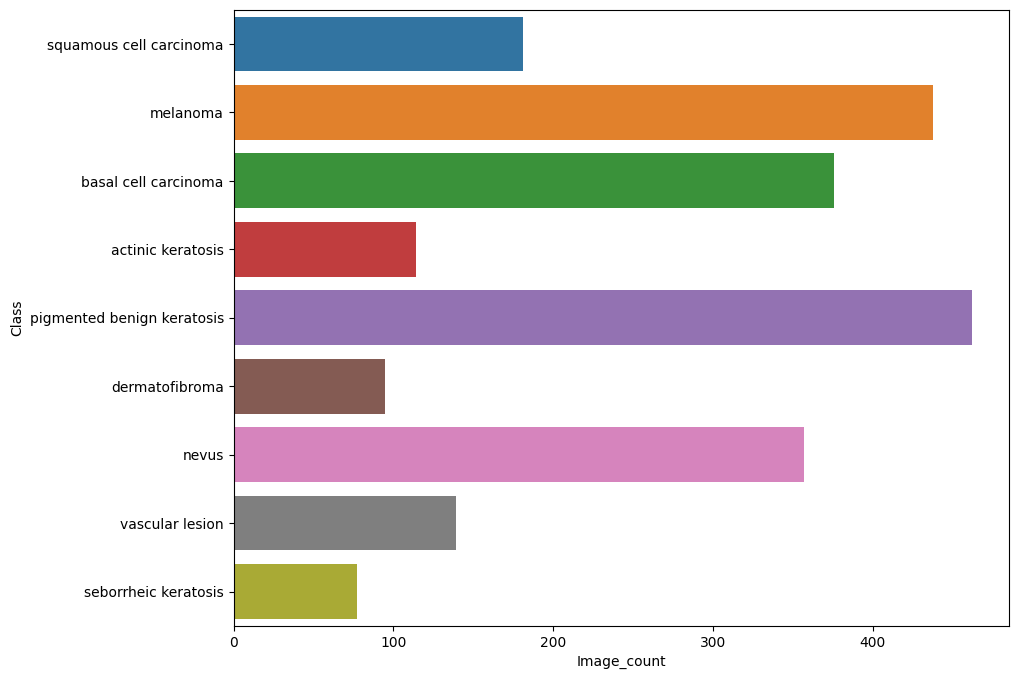

In [10]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x='Image_count',y='Class', data=df)
plt.show()

There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [11]:
#install Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import os
print(os.getcwd())

/content


In [14]:
path_to_training_dataset="/content/gdrive/MyDrive/Skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F9F8D61FD30>: 100%|██████████| 500/500 [01:45<00:00,  4.72 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA0D4637E80>: 100%|██████████| 500/500 [00:23<00:00, 21.71 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9F8D52E6A0>: 100%|██████████| 500/500 [00:49<00:00, 10.03 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA031EDBA90>: 100%|██████████| 500/500 [00:21<00:00, 22.95 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA031D0ADF0>: 100%|██████████| 500/500 [00:23<00:00, 21.23 Samples/s]


In [16]:
#Count total number of image generated by Augmentor.

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500
4500


**Model Building**

In [17]:
# train dataset 


#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.


train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,image_size=(180,180),
                                                               label_mode='categorical', seed=123, subset='training',
                                                               validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [18]:
# validation dataset 
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [19]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [20]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180,180,3))) #Rescaling layer
#First Convulation layer

model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))


#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.

model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

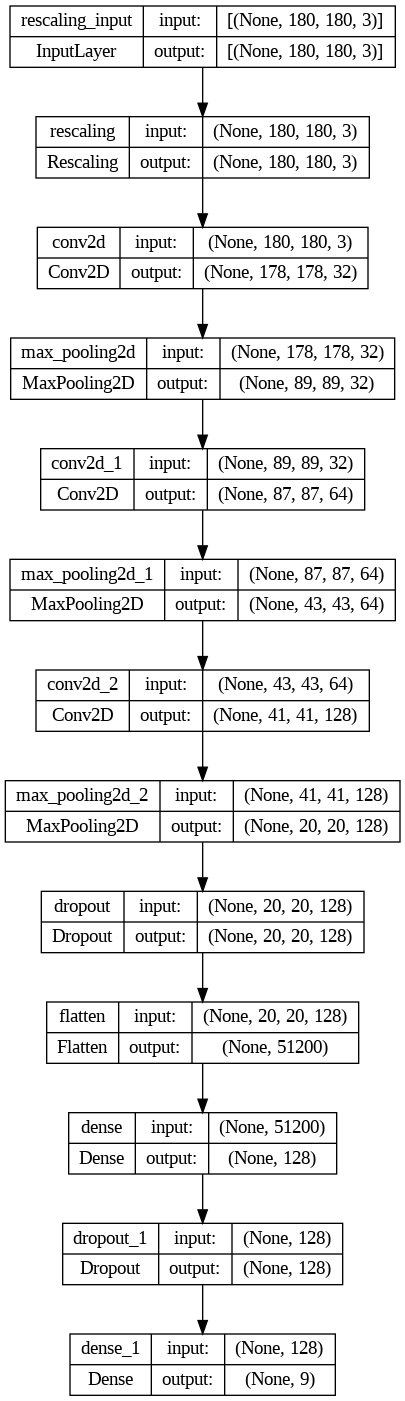

In [22]:
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
# vizualizing the model 


from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.


model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.

checkpoint = ModelCheckpoint("model.h5",monitor='val_accuracy',save_best_only=True,mode='auto',verbose=1)

#Stop training when a monitored metric has stopped improving.


earlystop = EarlyStopping(monitor='val_accuracy',patience=5, mode='auto', verbose=1)

In [28]:
# Train the model

epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])


Epoch 1: val_accuracy improved from -inf to 0.45731, saving model to model.h5
169/169 [==============================] - 58s 95ms/step - loss: 1.8012 - accuracy: 0.3088 - val_loss: 1.4352 - val_accuracy: 0.4573
Epoch 2/20
168/169 [============================>.] - ETA: 0s - loss: 1.4406 - accuracy: 0.4535
Epoch 2: val_accuracy improved from 0.45731 to 0.51522, saving model to model.h5
169/169 [==============================] - 9s 54ms/step - loss: 1.4405 - accuracy: 0.4527 - val_loss: 1.2920 - val_accuracy: 0.5152
Epoch 3/20
168/169 [============================>.] - ETA: 0s - loss: 1.2907 - accuracy: 0.5099
Epoch 3: val_accuracy improved from 0.51522 to 0.56347, saving model to model.h5
169/169 [==============================] - 9s 54ms/step - loss: 1.2905 - accuracy: 0.5096 - val_loss: 1.1802 - val_accuracy: 0.5635
Epoch 4/20
168/169 [============================>.] - ETA: 0s - loss: 1.1406 - accuracy: 0.5741
Epoch 4: val_accuracy improved from 0.56347 to 0.59614, saving model to mo

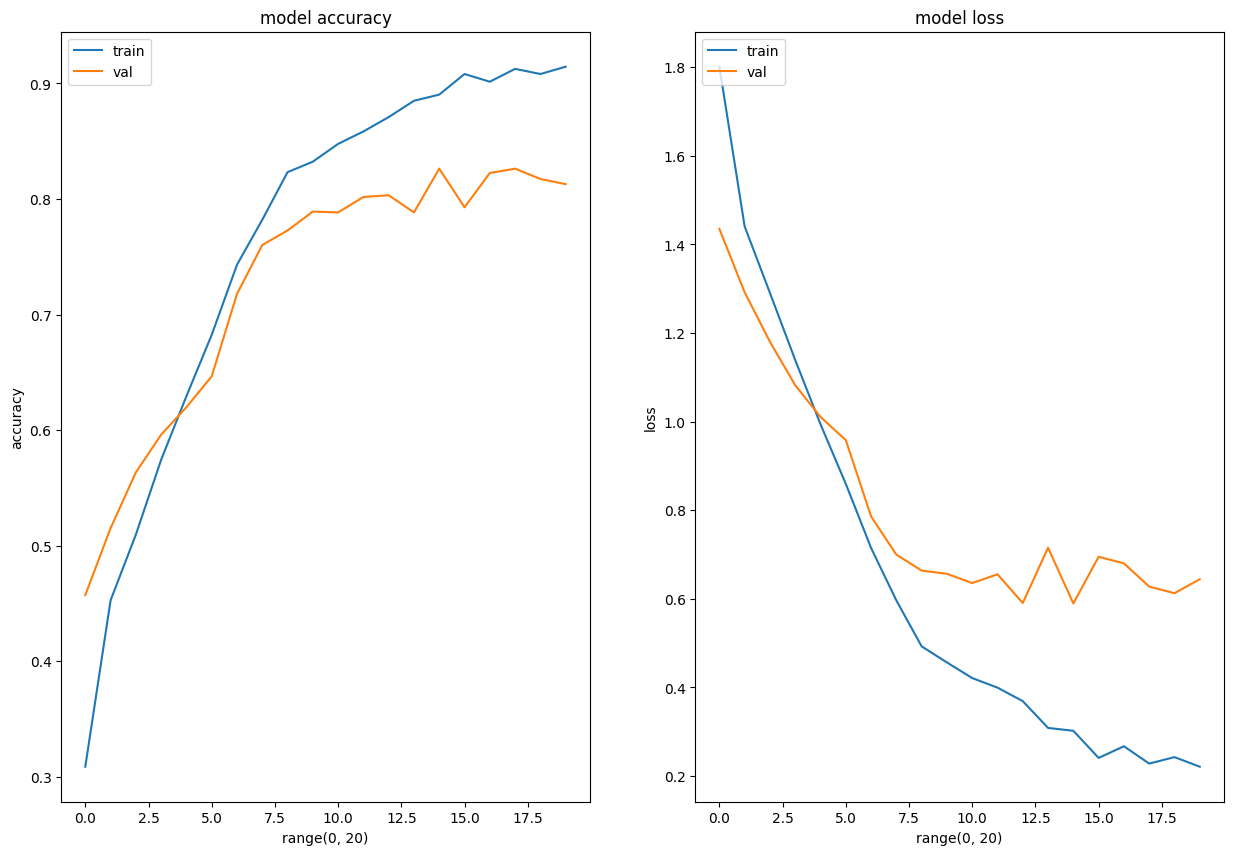

In [29]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Model Prediction

1/1 [==============================] - 0s 21ms/step
Actual Class basal cell carcinoma
Predictive Class pigmented benign keratosis


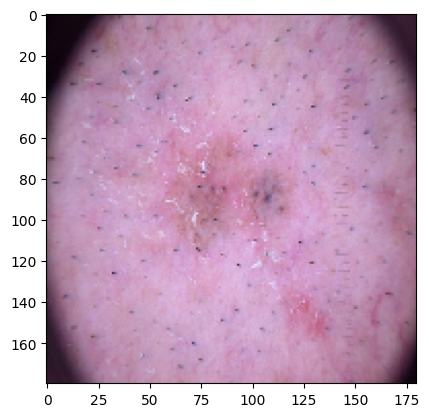

In [32]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )